# WeatherPy
----

In this analysis an answer to the question: What's the weather like as we approach the equator? is adrressed. Through this notebook the weather of, at least, 500 cities across the world of varying distance from the equator is obtained and analyzed. Data is retrieved from OpenweatherMap API, and the city name is obtained form the module citipy.

## Introduction
----

In NASA's we page [http://www.ces.fau.edu/nasa/module-3/why-does-temperature-vary/latitude.php] is briefly describe how does the angle of the sun rays affect temperaure. In this page it is explained that "*the angle of incoming solar radiation influences seasonal temperatures of locations at different latitudes. When the sun’s rays strike Earth’s surface near the equator, the incoming solar radiation is more direct (nearly perpendicular or closer to a 90˚ angle). Therefore, the solar radiation is concentrated over a smaller surface area, causing warmer temperatures. At higher latitudes, the angle of solar radiation is smaller, causing energy to be spread over a larger area of the surface and cooler temperatures. Because the angle of radiation varies depending on the latitude, surface temperatures on average are warmer at lower latitudes and cooler at higher latitudes (even though higher latitudes have more hours of daylight during the summer months)*".

Therefore it is expected that temperatures near the equator (latitude = 0°) to be higher than temmperatures of cities near the poles (latitudes = 90° or -90°). Here we suppose that pollution, climate change and other features are not important determinaning temperature (which is not true) but the analysis is kept simple.


In [34]:
#Lets import dependencies
import random #To generate random sets
import requests # to make api requests
import json #To manage api respose as json file
import time #To add sleep time in a computational process
import pandas as pd #To manage data sets as dataframes
import numpy as np # To create random lists
import matplotlib.pyplot as plt #To plot
from scipy import stats as st#To make regression and other statistical analysis
from datetime import datetime #To asj for current date
from citipy import citipy # Module to retieve the name of the closest city to a given pair of geocoordinates.
from config import weather_api_key #Place to store keys for APIs

## Generating random coordinates
- - - -

The coordinates of any location o Earth are given in a pair known as latitude and longitude.Latitude and Longitude are the units that represent the coordinates at geographic coordinate system. Latitude is contained in the interval $[-90°, 90°]$. And it measures the angle between the equatorial plane and the straight line that passes through that point and through (or close to) the center of the Earth. On the other hand, longitude is contained within the interval $[-180°, 180°]$. Longitude measures the angle east or west of a reference meridian to another meridian that passes through that point. [https://en.wikipedia.org/wiki/Geographic_coordinate_system]

Since it is necessary to generate, at least 500 cities, we are going to generate a big set of pair of coordinates. In order to cover in a symmetric way cities form north and south hemisphere, two latitude set  are generated and then combinaded puting in the even places of the combined list the positive values (north hemisphere) and in the odd positions the negative values of the latitude (south hemisphere).

In [2]:
#Since it is a random generator we fix the seed in order to get a reproducible code
#Fix the seed
random.seed(1234)

We are going to generate 800 numbers that lives in the interval $[0,90]$. This numbers represent the latitude of some ramdom point in the Earth's northern hemisphere.

In [3]:
# list of random float between a range from 0 to 90
latitudes_pos = np.random.uniform(0,90, size=800)

#Lets check what we got
print(f"Printing list of {len(set(latitudes_pos))} random northern hemisphere latitudes")
print(latitudes_pos)

Printing list of 800 random northern hemisphere latitudes
[88.87868667 23.7868919  21.55742175 58.01857598 20.41609683 81.98291536
 69.6069639  69.78834232  3.68488789 67.10755644 40.9277855  69.74093696
 88.13020452 75.14072836 19.84166143 79.11743893  4.17552381 20.69596361
  9.38643833 64.86170257 47.42851376 46.14004927 34.57458477 15.57964035
 22.11921792 77.27504847 59.57733575 16.74912369 62.58602738 14.90167578
 55.44540077 40.84161837 30.22083513 87.6342256  21.6875311  21.63586041
 10.06248852 76.44457017 75.66179513 62.29719024  8.95813133 12.67636654
 73.41629937 50.34383161 74.29240792 45.22459086 43.82734995  4.57292551
  8.98304225 82.8069419  78.34494382  4.16163683  4.2281477  84.18673547
 40.60443502 50.50665589 75.1785222  32.06502978 24.44545141 27.33539766
 70.37354518 76.5764378  17.46695905 32.44074524 57.22190679 76.8249551
  1.56505819 63.33491669 75.17535296 46.8158172  35.25637428 83.27306551
 41.33421069 24.05466823 62.62046547 64.2772575  60.77171939  8.004

This last process is repeated, but this negative random values between -90 and 0 are generated. In other words, 800 negative latitudes are created.

In [4]:
# list of random float between a range -90 to 0
latitudes_neg = np.random.uniform(-90,0, size=800)

#Lets check what we got
print(f"Printing list of {len(set(latitudes_neg))} random southern hemisphere latitudes")
print(latitudes_neg)

Printing list of 800 random southern hemisphere latitudes
[ -0.98710709 -13.20766898 -22.97796067 -61.1537665  -85.00317244
 -44.81541099  -7.51867023 -36.59602385 -50.04478152 -40.5073971
  -2.16842017 -25.2253386  -39.42936341 -66.09457298 -36.45765018
  -2.65437012 -11.79214046  -5.6952433  -31.96541212 -45.67052186
 -33.16901811 -23.44300401  -4.628436   -16.54991718 -47.75797091
 -34.65641652 -18.45207845 -23.09167585 -59.71394084 -22.40677099
  -6.64170732 -72.88250238 -85.76927008 -41.30587608 -81.79828421
 -29.84637416 -73.32532792 -30.20565955  -6.35121681 -49.1700466
 -84.89992743 -25.55287325 -63.62615641 -18.67980934 -67.50879403
 -76.31448157 -16.37994446  -5.12364273 -58.19809316 -62.34165487
 -45.53403944 -47.67446831 -46.41041464 -18.97152119 -32.61083624
  -2.54813331 -10.0654343  -36.22238385 -69.28028863 -28.98733994
 -31.61092101 -79.73227314 -41.94515511 -19.06384724 -21.17357232
 -47.37386766 -88.87544373 -48.1684006  -11.26420131 -63.95147275
 -83.13844961 -23.96

To somehow ensure that a balanced sample of cities in the northern and southern hemispheres will be obtained, the list of positive latitudes is interspersed with that of negative latitudes in a single list. In this way, the weather API will give information, in the best case, of a city in the north and another in the south and the final set will have at least 250 cities in the northern hemisphere and at least 250 cities in the southern hemisphere. It means that we are to merge the lists so that all elements from the first list are even-indexed (preserving their order) and all elements from second list are odd-indexed (also preserving their order).

In [5]:
#Lets combine the lists of latitudes
latitudes = [sub[i] for i in range(len(latitudes_neg)) for sub in [latitudes_pos, latitudes_neg]] + [latitudes_pos[-1]]
print(len(latitudes))
print(latitudes)

1601
[88.87868666503168, -0.9871070890891787, 23.78689189938247, -13.207668975082427, 21.55742175306129, -22.977960668690443, 58.01857598458403, -61.15376650127753, 20.41609683378248, -85.00317244320462, 81.98291535869352, -44.81541098600835, 69.60696390413895, -7.51867023177428, 69.78834232279047, -36.59602385013571, 3.6848878865529047, -50.044781523626305, 67.10755643777524, -40.50739710164129, 40.92778549925794, -2.1684201740004454, 69.74093695715504, -25.225338600149172, 88.13020451540932, -39.42936341223511, 75.14072836028919, -66.094572975971, 19.84166142940587, -36.457650176176436, 79.11743893012817, -2.6543701169544818, 4.175523812328415, -11.792140458683662, 20.695963607178765, -5.695243300021076, 9.386438334923726, -31.9654121181171, 64.86170256827575, -45.670521855299135, 47.42851376353435, -33.169018114337504, 46.140049271934316, -23.44300400624104, 34.57458477447096, -4.628436002889416, 15.579640349929605, -16.549917181038893, 22.11921792217019, -47.75797090666269, 77.2750

The last step to generate a pair of geo coordinates a set of 1601 random longitudes is going to be gereated. The same process for latitudes is followed except that we are not going to divide the random process in two sections. This time we gerate the complete set considering that logitud is contained in the interval $[-180, 180]$.


In [6]:
#The same for longitude a list of random float between a -180.0 and 180.0
longitudes = np.random.uniform(-180, 180, len(latitudes))

print(f"In total we generate {len(set(longitudes))} unique longitudes")
print(longitudes)

In total we generate 1601 unique longitudes
[ -21.8327779    27.86507246 -112.69592933 ...  150.95769374  131.05262899
  -23.82109658]


## Retreiving the closest city to the random set of coordinates
- - -  -

Now that we have generated a set of 1561 latitudes and a set of 1561 longitudes we have to find if there is a city nearby or located at a given pair (lat, long). Fortunately, there is a module called "*citipy*" designed by Wiston Cheng and Ahmed Haque [https://github.com/wingchen/citipy] . This module is designed to look for nearest city with geo coordinates, bu only count in the cities whose population is over 500. To use this module we just have to call the function nearest_city, feed it with a pair of coordinates (lat, long) and then extract from the result the city name and the country if it is necessary.

Now, to generate a pair (lat, long) a nested for loop is generated. First the loop goes trough the latitude list, and then another loop goes through the longitude list, *ie*, for each latitude there is going to be 1561 posible combinations. In this form we generate a very big amount of cities. This procedure will only have a problem, it could a have a lot of duplicates due to:

1. The generated latitudes might be very near and there might be unique city nearby that latitude

2. The generated longitudes might have bery close values and there might be only one unique city nearby that longitude

3. Somehow, the generated pairs (lat, lon) are nearby points in the world.

To avoid duplicated items a dictionary is created, and inside the for loop is genereted a  key value wich is goint to be given by "*city_name in country_code*" and the value of such key is going to be the name of the nearest city. Then with an if the key already exists then a counter with add a one, if not the key and value is added to the dictionary. 

One disadvantage of this approach is the time that the nested loop takes.

In [7]:
#create a list of pairs of coordinates
coordinates = [list(x) for x in zip(latitudes, longitudes)]

len(coordinates)

1601

In [8]:
#Lets create a dictionary
cities_dict ={}

#Counter to see how many cities are repeated
repeated_c = 1

#For nested loop
for coordinate in coordinates :
    #Ask for the nearest city to (x,y)
    city =  citipy.nearest_city(coordinate[0], coordinate[1])
    key_cd =f"{city.city_name}"
    #If else to check if the city is part of the dictionary or not
    if key_cd in cities_dict.keys() :
        repeated_c += 1
    else :
        cities_dict.update({key_cd : city.city_name})

In [9]:
#Lets print the results
print(f"The result is a dictionary of {len(cities_dict)} cities, with {repeated_c} repeated cities proposals.")


The result is a dictionary of 641 cities, with 961 repeated cities proposals.


In [10]:
#Lets create a list from de dictionary values
cities = list(cities_dict.values())
print(len(cities))
print(cities)

641
['illoqqortoormiut', 'goma', 'constitucion', 'rolim de moura', 'shenzhen', 'jamestown', 'homer', 'hobart', 'marawi', 'ushuaia', 'nizhneyansk', 'umzimvubu', 'yar-sale', 'atuona', 'attawapiskat', 'rikitea', 'kavieng', 'bluff', 'thompson', 'lakes entrance', 'nikolskoye', 'ijaki', 'lakselv', 'werda', 'mahebourg', 'belushya guba', 'mar del plata', 'ponta do sol', 'cape town', 'barrow', 'tome-acu', 'takoradi', 'sao jose da coroa grande', 'paciran', 'kavaratti', 'tsihombe', 'storforshei', 'cuiluan', 'san luis', 'little current', 'georgetown', 'san francisco del mar', 'sao luis de montes belos', 'codrington', 'castro', 'narsaq', 'ngunguru', 'kropotkin', 'poum', 'guerrero negro', 'farafangana', 'pangnirtung', 'albany', 'butaritari', 'isangel', 'beringovskiy', 'torbay', 'saint george', 'bredasdorp', 'tuktoyaktuk', 'mataura', 'hilo', 'broken hill', 'bousso', 'chokurdakh', 'rio pardo', 'hithadhoo', 'harnosand', 'cidreira', 'cabo san lucas', 'hermanus', 'cayenne', 'pisco', 'saskylakh', 'taolana

It has to be noted that even there might be some duplicated city names that might correspond to different cities as for example the city St. Petersburg, Florida, which is actually named after the famous Russian city.[https://www.insider.com/places-with-same-name-around-the-world-2018-5]

 ## Requesting weather information
 
 Once the set of random is cities is generated, then it is possible to request weather information of such cities. This is done using the API Current weather data from Current OpenWeather[https://openweathermap.org/current].
 
 This API needs some parameters to make a query by city, which are listed below:
 
 * Base addres: api.openweathermap.org/data/2.5/weather?
 
 * q parameters: that can be de city name, the state code, and the country code
 
 *  appid : An api key, unique for each user
 
 * units: Standard, metric, and imperial units are available.
 

The addres to make a request should look like this: 
 
 api.openweathermap.org/data/2.5/weather?q={city name},{state code},{country code}&units={K, imperial, metric}&appid={your api key}
 
The result, if the city has weather stations, could be a json file that contains several data such as the coordinates, the main temperature, main.feels_like Temperature, Atmospheric pressure, Humidity (%), Minimum temperature at the moment, maximum temperature at the moment, Wind speed, Wind direction, Wind gust. Cloudiness, (%), rain volume, snow volume, etc.

In this section, a loop is used to loop through all possible cities stored in the list cities generated before. The result of each iteration is stored in a dictionary whose keys are the name of the city and the values are a list of characteristics of the city's weather. Inside the for loop, an if statement is introduced to check if the city already exists in the dictionary keys. If the name of the city is not yet part of the dictionary, the information is requested from the api through the Try and except method, since it is possible that the Api system does not have information for that city. It is important to mention that the cycle is limited through a counter, that when it reaches 500 it breaks the loop.

In [11]:
#Lets get the parameters to make an api request to open weather

#Save the fix url
url = "http://api.openweathermap.org/data/2.5/weather?"
#Save the parameter unit
unit = "imperial"
#Build a partial query url
query_url=f"{url}appid={weather_api_key}&units={unit}&q="


In [13]:
#Lets loop throug the cities list
#Create empty dictionary
cities_dict = {}

#Creat a counter for the times that the API did find a city
number_cities = 1

#Count how many cities are repeated.
repeated_c = 0


#Lets loop throug the list of cities and perform a request for each city
for city in cities:
    #Lets get the variables, first lets see if he have that city in the dictionary is so add 1 to reapeated_C
    if city in cities_dict.keys() :
        #Add one to reapeated
        repeated_c += 1
    else :
        #Create a response
        response = requests.get(query_url+city).json()
        try:
            lon = response["coord"]["lon"] #get the latitude
            lat = response["coord"]["lat"] #get the longitude
            temp = response["main"]["temp"] # get temperature
            temp_max = response["main"]["temp_max"] #get maximum temperature
            hum = response["main"]["humidity"] #extract humidity
            clo = response["clouds"]["all"] #extract clouds
            wind = response["wind"]["speed"] # extract wind
            #construct a list
            valores = [lat, lon, temp,temp_max,hum,clo,wind]
            #Lets add a new key
            cities_dict.update({city : valores})
            number_cities += 1
            #Lets print a mesage
            print(f"Information of {city} retrieved, call number {number_cities-1}")
            time.sleep(1)
        except:
            print(f"Sorry {city} not found")
            time.sleep(1)



Sorry illoqqortoormiut not found
Information of goma retrieved, call number 1
Information of constitucion retrieved, call number 2
Sorry rolim de moura not found
Information of shenzhen retrieved, call number 3
Information of jamestown retrieved, call number 4
Information of homer retrieved, call number 5
Information of hobart retrieved, call number 6
Information of marawi retrieved, call number 7
Information of ushuaia retrieved, call number 8
Sorry nizhneyansk not found
Sorry umzimvubu not found
Information of yar-sale retrieved, call number 9
Information of atuona retrieved, call number 10
Sorry attawapiskat not found
Information of rikitea retrieved, call number 11
Information of kavieng retrieved, call number 12
Information of bluff retrieved, call number 13
Information of thompson retrieved, call number 14
Information of lakes entrance retrieved, call number 15
Information of nikolskoye retrieved, call number 16
Sorry ijaki not found
Information of lakselv retrieved, call number 

Information of bac lieu retrieved, call number 155
Information of jalu retrieved, call number 156
Information of kenai retrieved, call number 157
Information of omsukchan retrieved, call number 158
Information of beibei retrieved, call number 159
Information of bady bassitt retrieved, call number 160
Sorry sorvag not found
Information of pathein retrieved, call number 161
Information of faanui retrieved, call number 162
Information of rosarito retrieved, call number 163
Information of qaanaaq retrieved, call number 164
Information of rundu retrieved, call number 165
Information of olafsvik retrieved, call number 166
Information of kalabo retrieved, call number 167
Information of lompoc retrieved, call number 168
Information of new norfolk retrieved, call number 169
Information of coahuayana retrieved, call number 170
Information of yulara retrieved, call number 171
Sorry vaitupu not found
Information of baoshan retrieved, call number 172
Information of kiruna retrieved, call number 173

Information of qurayyat retrieved, call number 312
Information of matehuala retrieved, call number 313
Information of alfeld retrieved, call number 314
Information of grand-santi retrieved, call number 315
Information of carballo retrieved, call number 316
Information of kutum retrieved, call number 317
Information of miraflores retrieved, call number 318
Information of poya retrieved, call number 319
Information of kirillov retrieved, call number 320
Sorry rungata not found
Information of ust-omchug retrieved, call number 321
Information of port hedland retrieved, call number 322
Information of chumikan retrieved, call number 323
Information of thaton retrieved, call number 324
Information of assiniboia retrieved, call number 325
Information of biloela retrieved, call number 326
Information of frederikshavn retrieved, call number 327
Information of ust-kut retrieved, call number 328
Information of gafanha da encarnacao retrieved, call number 329
Information of geraldton retrieved, cal

Sorry itapua poty not found
Information of biak retrieved, call number 467
Information of ayolas retrieved, call number 468
Information of korla retrieved, call number 469
Information of alindao retrieved, call number 470
Information of praia da vitoria retrieved, call number 471
Information of the valley retrieved, call number 472
Information of batesville retrieved, call number 473
Information of moscow retrieved, call number 474
Information of harper retrieved, call number 475
Information of hargeysa retrieved, call number 476
Information of princeville retrieved, call number 477
Information of gazojak retrieved, call number 478
Information of te anau retrieved, call number 479
Information of santa maria retrieved, call number 480
Information of arlit retrieved, call number 481
Information of taoudenni retrieved, call number 482
Information of boyolangu retrieved, call number 483
Information of luderitz retrieved, call number 484
Information of limot retrieved, call number 485
Infor

In [14]:
#Lets check the length of the dictionay (it must be at least 500)
len(cities_dict)

592

In [15]:
#Lets convert into a pandas df
cities_df = pd.DataFrame.from_dict(cities_dict, orient='index', 
                                   columns=["Longitude", "Latitude", "Temperature","Max Temperature", "Humidity", "Cloudiness","Wind Speed"])

cities_df

,Longitude,Latitude,Temperature,Max Temperature,Humidity,Cloudiness,Wind Speed
goma,-1.68,29.22,65.79,65.79,65,56,2.21
constitucion,-35.33,-72.42,52.63,52.63,75,69,5.79
shenzhen,22.55,114.07,83.26,84.00,98,4,3.49
jamestown,42.10,-79.24,66.40,66.99,52,1,16.11
homer,59.64,-151.55,53.53,55.40,71,75,5.82
...,...,...,...,...,...,...,...
manokwari,-0.87,134.08,83.03,83.03,69,15,1.74
vengerovo,55.68,76.75,44.89,44.89,91,100,11.21
fuerte olimpo,-21.04,-57.87,81.39,81.39,35,3,0.72
kidal,18.44,1.41,88.18,88.18,42,85,13.18


In [16]:
#check correct latitude title
print(f"The max latitude is {cities_df['Latitude'].max()} and the max longitude is {cities_df['Longitude'].max()}")

The max latitude is 179.32 and the max longitude is 78.22


In [17]:
cities_df.rename(columns={'Latitude': 'Longitude', 'Longitude':'Latitude'}, inplace=True)

In [18]:
#Lets reset the index
cities_df.reset_index(inplace = True)
#Lets change the name of the first column
cities_df.rename(columns={'index':'City'}, inplace=True)
cities_df

,City,Latitude,Longitude,Temperature,Max Temperature,Humidity,Cloudiness,Wind Speed
0,goma,-1.68,29.22,65.79,65.79,65,56,2.21
1,constitucion,-35.33,-72.42,52.63,52.63,75,69,5.79
2,shenzhen,22.55,114.07,83.26,84.00,98,4,3.49
3,jamestown,42.10,-79.24,66.40,66.99,52,1,16.11
4,homer,59.64,-151.55,53.53,55.40,71,75,5.82
...,...,...,...,...,...,...,...,...
587,manokwari,-0.87,134.08,83.03,83.03,69,15,1.74
588,vengerovo,55.68,76.75,44.89,44.89,91,100,11.21
589,fuerte olimpo,-21.04,-57.87,81.39,81.39,35,3,0.72
590,kidal,18.44,1.41,88.18,88.18,42,85,13.18


### Inspect the data and remove the cities where the humidity > 100%
- - - - 

In order to remove data with very high humidity we are going to create a list of boolean data, where *True* corresponds to humidity values greater than $100\%$ and false is less than $100\%$. It is proposed a loop to iterate trhoug the boolean list.

In [19]:
#Lets get the currect date
date_t = datetime.date(datetime.now())

#Define an empty list
indices_bool = []

#Define a counter thar keep track of the numeber of times the foor loop makes an iteration
conta = 0

#Lest ask if there are valus greater than 100
humidity_probe = list(cities_df['Humidity']>100)
#Lest count them
count = humidity_probe.count(True)

#If there is at least one case with humidity greater than 100, then enter to the cicle to locate the position of than value
if count != 0:
    for bool_val in humidity_probe:
        if prueba[bool_val] == True:
            #Ask if the entry in the list is true if so append the value in the counter
            indices_bool.append(conta)
            #Add one value to the counter
            conta +=1
        else:
            conta +=1
    #Filter df
    Filter_df  = cities_df[cities_df.index.isin(indices_bool)]
    print(f"In the {date_t} querry there were {count} values with Humidity greater than 100%, check Filter_df")
else :
    print(f"In the {date_t} querry there were {count} values with Humidity greater than 100%")

#Filter_df

In the 2020-09-04 querry there were 0 values with Humidity greater than 100%


  Since there aren´t cities with humidity values greater than $100\%$, no filter has to be added. 

In [20]:
#Lets save the df
save_dir = "C:/Users/avalo/OneDrive/Documentos/TAREAS/python-api-challenge/WeatherPy/output_data/"

#Use pandas dataframe.to_csv
cities_df.to_csv(f"{save_dir}cities_weather.csv", sep=',',header=True, index=False)

## Latitude vs. Temperature Plot
- - - -

In this section a scatter plot of the latitude versus the temperature is done.  It is used the pandas scatter function, whose arguments are: 

* x, the values for x axis contained in a colum of the dataframe

* y, the values for y axis, also contained in a colum of the dataframe

* c, the color of the points

* title, the desired title for the graph

* grid, boolean True add a grid

* etc [https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html]


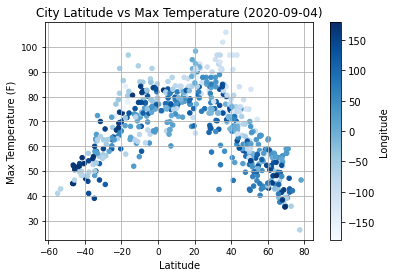

In [24]:
#Lets plot the lat vs temp
#Use fig, plt.subplost to plot xticks and x label if not thy do not appear

fig, ax = plt.subplots()
cities_df.plot(kind='scatter', x='Latitude', y='Max Temperature', title =f"City Latitude vs Max Temperature ({date_t})",
                            c = 'Longitude', colormap='Blues',grid=True, fontsize = 9, ax=ax)
ax.set_ylabel('Max Temperature (F)')
#
plt.savefig(f"{save_dir}plot_1.png")

This plot shows that there migh be relationship between latitude and the maximum temperatue. Indeed it looks almost as an inverted U centered arround zero. It could be interpreted as the farthest from zero and closer to 90 or -90 degrees the coldest the temperature is. 

## Latitude vs Humidity plot
- - - -


In this section a scatter pandas plot is presented. This time, latitude is constrasted with humnidity in (%). The code is similar to the one of the last plot.

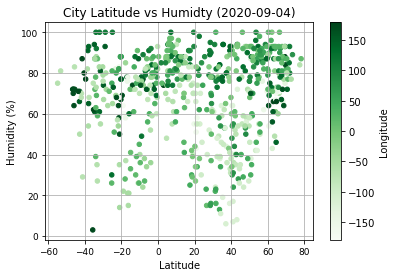

In [25]:
fig, ax = plt.subplots()
cities_df.plot(kind='scatter',x='Latitude', y='Humidity', title =f"City Latitude vs Humidty ({date_t})", 
                            c='Longitude', colormap='Greens' ,grid=True, fontsize = 9, ax=ax)
ax.set_ylabel("Humidity (%)")
plt.savefig(f"{save_dir}plot_2.png")
plt.show()

In this plot there is not a clear pattern between latitude and humidity. It is observed that almost all the darkest green points have greater values of humidity, except for one point at almost -40 degrees of latitude that has an humidity around zero.

##  Latitude vs Cloudiness plot
- - - - 

As the other two plots above in the following scatter plot the latitude is compared with the cloudiness (%).

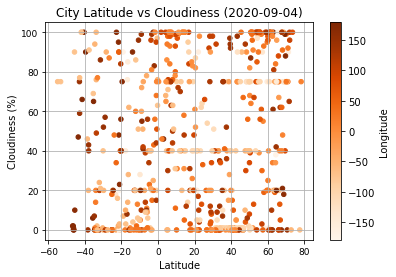

In [26]:
fig, ax = plt.subplots()
cities_df.plot(kind='scatter', x="Latitude", y="Cloudiness", title=f"City Latitude vs Cloudiness ({date_t})", 
                            c='Longitude', colormap='Oranges', grid=True, fontsize = 9, ax=ax)
ax.set_ylabel('Cloudiness (%)')
plt.savefig(f"{save_dir}plot_3.png")
plt.show()

In this graph there is also not clear paterns, it is observed that a given latitude and longitude there might be a lot of diferent amounts of cloudines in the same latitude.

##  Latitude vs Wind Speed Plot
- - - -

Finally, as above, a scatterplot is done to compare the latitude with the wind speed in miles per hour.

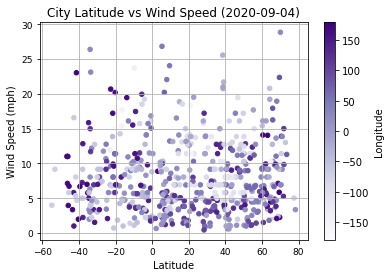

In [27]:
fig, ax = plt.subplots()

cities_df.plot(kind='scatter', x="Latitude", y="Wind Speed", title =f"City Latitude vs Wind Speed ({date_t})",
                             c= 'Longitude', colormap='Purples', grid=True, fontsize = 9, ax=ax)
ax.set_ylabel('Wind Speed (mph)')


plt.savefig(f"{save_dir}plot4.png")
plt.show()

In this plot there is not a clear relationship between wind speed and the latitude. It os observed that most of the points are located below the value of 15 mph. Also in a given latitude there might be a wide variety of wind speeds. However, this last sentence has to be taken with care.

## Northern hemisphere vs  south hemisphere
- - - - 

From the four scatterplots above it seems that there is some  relationship between weather and the latitude. Therefore, some analysis is going to be done by hemisphere. To do so, the original dataframe of weather for each city is going to be divided by latitude. Generating one dataframe with latitudes grater or equal to zero, *i.e.* cities of the Northern Hemisphere, and another one with latitudes less than cero, or cities in the Southern Hemisphere.

In [28]:
#Lets divide the original dataframe 

#Filter for cities of northern hemisphere latitude E [0, 90]
cities_nh = cities_df.loc[cities_df['Latitude']>= 0,]
cities_nh.shape

(407, 8)

In [29]:
#Filter for cities of southern hemisphere latitude E [-90, 0)
cities_sh = cities_df.loc[cities_df['Latitude']< 0,]
cities_sh.shape

(185, 8)

It is observed that there are more data points for the Northern hemisphere than  for the Souther hemisfere.

Since a lot of graphs are going to be done, then a function is going to be created. The function will require four arguments. The x list of values, the y list of values, a string that contains the y label and a string that contains the main title of the graph. With these values the function will do the following steps:

1. Estimate the correlation between x and y

2. Estimate the linear regression between x and y

3. Plot a scatter plot of x versus y and the plot of x vs the estimated values of y

4. It will print a line with the correlation value and its p-value

5. It will print a line with the r squared value and the p-value f the regression.

In the next cell the function is constructed and named "*weather_reg*".



In [38]:
#Lets create a function to get the regression and plot the regression
def weather_reg(x,y,y_label, my_title, name_p):
    #Correlation
    corr, cp_val = st.pearsonr(x,y)
    #Regression
    slope, intercept, r_value, rp_value, std_err = st.linregress(x,y)
    #Build a string with the regression equation
    reg_eq = f"y={round(slope,4)}x + {round(intercept,4)}"
    #Estimate the y values
    y_est = round((slope*x)+intercept, 4)
    
    
    #Lets extract some values for position of equation
    x_pos = min(x)
    y_pos = max(y)
    
    #Lets make a graph
    plt.scatter(x,y) #scatter plor of real values
    plt.plot(x,y_est, 'r-') # line plot of estimated values
    plt.xlabel('Latitude') #add x label
    plt.ylabel(y_label) #ad y label
    plt.title(my_title) # add a title to the graph
    plt.annotate(reg_eq,(x_pos,y_pos),fontsize=13,color='red') # add the regression eq to the plot
    plt.savefig(f"{save_dir}{name_p}.png")
    plt.show() #print the plot
    
    print(f"The correlation is {round(corr,2)} with a p-value = {cp_val}")
    print(f"The R squared of the regression is {r_value**2}")
    

### Norther Hemisphere - Max Temperature vs Latitude
- - - -

In this subsection a linear regresión of the maximum temperature vs latitude for the northern hemisphere is done by using the weather_reg funtion.

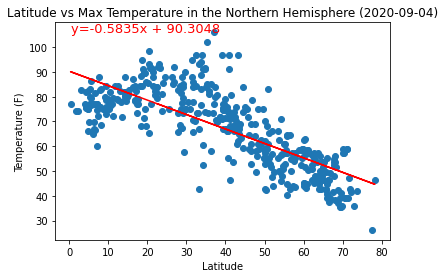

The correlation is -0.76 with a p-value = 2.059579865415742e-77
The R squared of the regression is 0.5757340651956839


In [41]:
#Lets create the variables that will be the arguments of the function weather reg
#Make a list of the latitudes (independent variable)
x_1 = cities_nh['Latitude']
#Make a list of the temperature (dependent variable)
y_1= cities_nh['Max Temperature']
#Create a string with the title of the graph
title_1 = f"Latitude vs Max Temperature in the Northern Hemisphere ({date_t})"
#Create a string with the y label
ylab_1 ="Temperature (F)"
#Create a string for the name
name = "plot5"
#Use the weather_reg function to generate a plot and regression
weather_reg(x=x_1, y=y_1, y_label=ylab_1, my_title=title_1, name_p=name)



If a linear regression model is fitted to the data for Northern Hemisphere, it is observed that the greater the latitude the smaller the temperature. This observation is reflected in the negative value of the slope. Also, the intercept might be interpreted as the mean maximum temperature at the Equator. It is important to nothe than there are many points far from the red line, because there is a wide variation of the temperate vales, also the relationship might not be well represented by a linear regresion as indicated by the p value of the correlation coefficient.



### Southern Hemisphere  - Max Temperature vs Latitude
- - - - 

Now the souther hemisphere data is going to be used. Again a comparison between Latitude and Maximum temperature is going to be done through a graph and a regression line. For this, the function *weather_reg* is going to be used

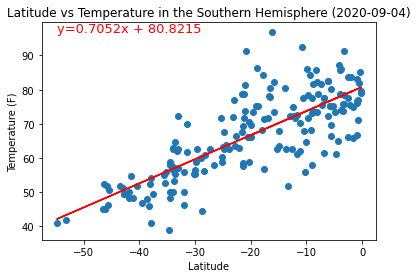

The correlation is 0.78 with a p-value = 8.781701158241782e-40
The R squared of the regression is 0.6150029377310786


In [42]:
#Lets create the variables that will be the arguments of the function weather reg
#Make a list of the latitudes (independent variable)
x_2 = cities_sh['Latitude']
#Make a list of the temperature (dependent variable)
y_2= cities_sh['Temperature']
#Create a string with the title of the graph
title_2 = f"Latitude vs Temperature in the Southern Hemisphere ({date_t})"
#Create a string with the y label
ylab_2 ="Temperature (F)"
#Create a string with the name of the file
name ="plot6"
#Use the weather_reg function to generate a plot and regression
weather_reg(x=x_2, y=y_2, y_label=ylab_2, my_title=title_2, name_p=name)

In the case of the Southern Hemisphere the linear regresion shows that the grater the latitude the greater temperature. For this regression it is observed that the slope is positive and the intercept has a similar value to the one of the norther hemisphere. Therefore the max temperature in the equator is in average around 85 F. In this case there is a bigger variation of temperatures, noted in the separation between data points. Also the linear regression might not be the best approach to model the temperature as a function of the latitude. Perhaps, for both hemispheres, a polinomial or log transformation might work.

### Northern Hemisphere - Humidity (%) vs. Latitude 
- - - -

Lets see if there is a linear relation between Humidity and Latitude. For this we use the *weather_reg* function. It has to be noted that it is not necessary to create a variable for the independent variable (x=latitude).

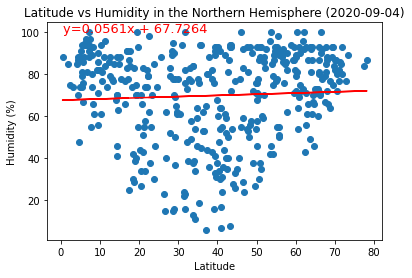

The correlation is 0.05 with a p-value = 0.2963713111073331
The R squared of the regression is 0.002692166462025051


In [43]:
#Lets create the variables that will be the arguments of the function weather reg
#Make a list of the temperature (dependent variable)
y_1= cities_nh['Humidity']
#Create a string with the title of the graph
title_1 = f"Latitude vs Humidity in the Northern Hemisphere ({date_t})"
#Create a string with the y label
ylab_1 ="Humidity (%)"
#Create a string with the name of the file
name="plot7"
#Use the weather_reg function to generate a plot and regression
weather_reg(x=x_1, y=y_1, y_label=ylab_1, my_title=title_1, name_p=name)


Here is evident that there is not a clear linear regresion of Humidity with latitudes in the Northern Hemisphere. Not even another kind of non linear regresision. This is reinforced by the value of the linear correlation. Also, the R squared value is very low which means that the regression does not model data very well. 

### Southern Hemisphere - Humidity (%) vs. Latitude 
- - - - 

Lets see if there is a linear relation between Humidity and Latitude. For this we use the *weather_reg* function. Note that is not necessry to define the x values again.

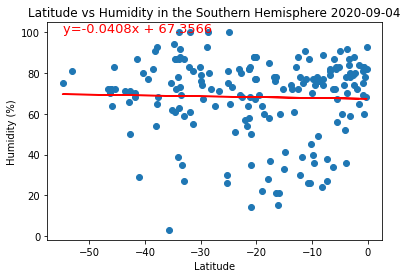

The correlation is -0.03 with a p-value = 0.7026644602887292
The R squared of the regression is 0.0007981159795666556


In [44]:
#Lets create the variables that will be the arguments of the function weather reg
#Make a list of the temperature (dependent variable)
y_2= cities_sh['Humidity']
#Create a string with the title of the graph
title_2 = f"Latitude vs Humidity in the Southern Hemisphere {date_t}"
#Create a string with the y label
ylab_2 ="Humidity (%)"
#Create a string with the name of the file
name="plot8"
#Use the weather_reg function to generate a plot and regression
weather_reg(x=x_2, y=y_2, y_label=ylab_2, my_title=title_2, name_p=name)

In this case the correlation is negative and low, also it has a p valuE smaller than 0.05. Therefore, there is statistical evidence that the correlation is negible. Also, the model can´t be trusted since it has a R squared value near to zero, which means that the model expalins a very low amount of data.

### Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
- - - -

In this section the relation between cloudiness and latitude is investigated thruough a linear regression by using the function *weather_reg*. We use x1 from temperature vs latitude plot.

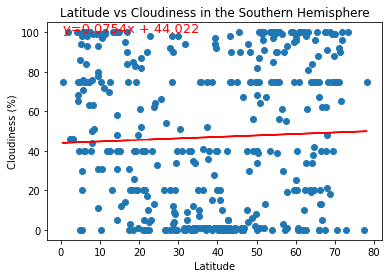

The correlation is 0.04 with a p-value = 0.4176253063436369
The R squared of the regression is 0.0016228779999456582


In [45]:
#Lets create the variables that will be the arguments of the function weather reg
#Make a list of the temperature (dependent variable)
y_1= cities_nh['Cloudiness']
#Create a string with the title of the graph
title_1 = "Latitude vs Cloudiness in the Southern Hemisphere"
#Create a string with the y label
ylab_1 ="Cloudiness (%)"
#String with the name of the file
name="plot9"
#Use the weather_reg function to generate a plot and regression
weather_reg(x=x_1, y=y_1, y_label=ylab_1, my_title=title_1, name_p = name)

For cloudiness there is no evidence of a linear regresion in function of latitude. For cloudiness it could be useful a log regresion to see the probability to have cloudy day in a given latitude, but is is necesarry to combine other weather data such as, humidity and wind velocity.

### Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
- - - -

In this section the relation between cloudiness and latitude is investigated thruough a linear regression by using the function weather_reg. We use x2 from temperature vs latitude plot.

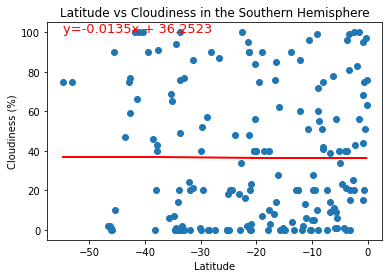

The correlation is -0.01 with a p-value = 0.9417474938382143
The R squared of the regression is 2.9258427786754378e-05


In [46]:
#Lets create the variables that will be the arguments of the function weather reg
#Make a list of the temperature (dependent variable)
y_2= cities_sh['Cloudiness']
#Create a string with the title of the graph
title_2 = "Latitude vs Cloudiness in the Southern Hemisphere"
#Create a string with the y label
ylab_2 ="Cloudiness (%)"
#String with name of the file
name="plot_10"
#Use the weather_reg function to generate a plot and regression
weather_reg(x=x_2, y=y_2, y_label=ylab_2, my_title=title_2, name_p=name)

It is observed the same phenomena as in the case of the northen hemisphere.

### Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
- - - -

This is the last graph for the Northern Hemisphere. It is going to be compared Wind speed with the latitude of the different cities. It is important to keep in moind that the x1 list is going to be used as independent variable.

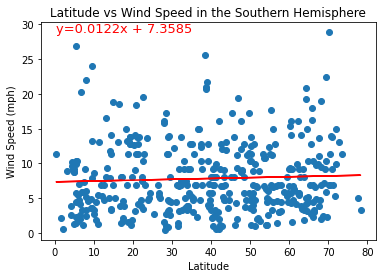

The correlation is 0.05 with a p-value = 0.3241709598862148
The R squared of the regression is 0.0024001877030072685


In [48]:
#Lets create the variables that will be the arguments of the function weather reg
#Make a list of the temperature (dependent variable)
y_1= cities_nh['Wind Speed']
#Create a string with the title of the graph
title_1 = "Latitude vs Wind Speed in the Southern Hemisphere"
#Create a string with the y label
ylab_1 ="Wind Speed (mph)"
#String with name of files
name="plot_11"
#Use the weather_reg function to generate a plot and regression
weather_reg(x=x_1, y=y_1, y_label=ylab_1, my_title=title_1, name_p=name)

Also for this variable there is not a clear linear relationship between latitude and wind speed. Indeed, wind speed is determined toug other factors, such as temparature, preassure, etc., and not necessarily latitude.

### Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
- - - -

This is the final contrart between variables done for the Southern Hemisphere. It is investigated if wind speed has a linear relationship with latitude. The function *weather_reg* and the x2 coordinate as independent variable are used

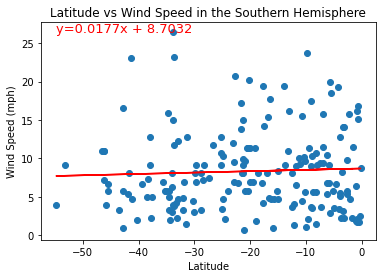

The correlation is 0.05 with a p-value = 0.5280281635114857
The R squared of the regression is 0.0021794471133512803


In [49]:
#Lets create the variables that will be the arguments of the function weather reg
#Make a list of the temperature (dependent variable)
y_2= cities_sh['Wind Speed']
#Create a string with the title of the graph
title_2 = "Latitude vs Wind Speed in the Southern Hemisphere"
#Create a string with the y label
ylab_2 ="Wind Speed (mph)"
#String with the name of the plo
name = "plot_12"
#Use the weather_reg function to generate a plot and regression
weather_reg(x=x_2, y=y_2, y_label=ylab_2, my_title=title_2, name_p=name)

The same observation for this case, but in the Northern Hemisphere, is applicable.

## Final remarks
- - - -

From the analysis above, it is observed that:

1. In effect, the temperature increases as the city is closer to the Equator.

2. In the norther hemisphere the slope of the linear regression of temperature vs longitude is negative while in the souther hemisphere is positive (This coul change of absolute value is applied to latitude for the souther hemisphere)

3. Humidity, cloudiness, and wind speed does not show evidence of a linear relatioship

4. Other models migh work better for all the comparisons. For example, a logistic regresión to work with probabilities of a given humidity or cloudiness might be useful.